In [1]:
import logging; logging.basicConfig(level=logging.DEBUG)
from __future__ import absolute_import, unicode_literals, print_function
import warnings

import matplotlib as mpl
import matplotlib.collections
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import path_helpers as ph
import pint
import svg_model

# Prevent `RuntimeWarning` messages from printing due to `np.nan` values in
# `get_intersections()` comparisons.
warnings.filterwarnings("ignore",category =RuntimeWarning)

ureg = pint.UnitRegistry()

%matplotlib inline

In [2]:
def get_segments(df_shapes, distance_threshold=0.1 * ureg.mm):
    distance_threshold_px = (distance_threshold * 96 * ureg.pixels_per_inch).to('pixels')
    df_segments = (df_shapes.groupby('id').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
                   .join(df_shapes.groupby('id').apply(lambda x: x.iloc[1:]).reset_index(drop=True),
                         rsuffix='2'))[['id', 'vertex_i', 'vertex_i2', 'x', 'y', 'x2', 'y2']]
    v = (df_segments[['x2', 'y2']].values - df_segments[['x', 'y']]).values
    mid = .5 * v + df_segments[['x', 'y']].values
    x_mid = mid[:, 0]
    y_mid = mid[:, 1]
    length = np.sqrt((v ** 2).sum(axis=1))
    v_scaled = distance_threshold_px.magnitude * v  / length[:, None]
    x_normal = -v_scaled[:, 1]
    y_normal = v_scaled[:, 0]
    
    df_normal = pd.DataFrame(np.column_stack([x_mid, y_mid, length, x_normal, y_normal]),
                             columns=['x_mid', 'y_mid', 'length', 'x_normal', 'y_normal'])
    return df_segments.join(df_normal).set_index(['id', 'vertex_i'])


def get_intersections(df_segments, p, r):
    # See: https://stackoverflow.com/a/565282/345236
    q = df_segments[['x', 'y']].values
    s = df_segments[['x2', 'y2']].values - q

    r_x_s = np.cross(r, s)
    r_x_s[r_x_s == 0] = np.NaN
    t = np.cross((q - p), s) / r_x_s
    u = np.cross((q - p), r) / r_x_s

    df_tu = pd.DataFrame(np.column_stack([t, u]), columns=list('tu'), index=df_segments.index)
    df_i = df_segments.join(df_tu).loc[(r_x_s != 0) & (t >= 0) & (t <= 1) & (u >= 0) & (u <= 1)]
    intersect_points = p + df_i.t.values[:, None] * r
    return df_i.join(pd.DataFrame(intersect_points, columns=['x_intersect', 'y_intersect'],
                                  index=df_i.index)).drop(['t', 'u'], axis=1)


def get_all_intersections(df_shapes, distance_threshold=0.1 * ureg.mm):
    df_segments = get_segments(df_shapes, distance_threshold=distance_threshold)

    intersections = []
    for i, ((id_i, vertex_i), segment_i) in enumerate(df_segments.iterrows()):
        p = segment_i[['x_mid', 'y_mid']].values
        r = segment_i[['x_normal', 'y_normal']].values

        df_intersections_i = get_intersections(df_segments, p, r)
        df_intersections_i = df_intersections_i.loc[df_intersections_i.index.get_level_values('id') != id_i]
        if df_intersections_i.shape[0]:
            intersections.append(((id_i, vertex_i), df_intersections_i))
    index, values = zip(*intersections)
    df_result = pd.concat(values, keys=index)
    df_result.index.names = ['id', 'vertex_i', 'id_neighbour', 'vertex_i_neighbour']
    return df_result

In [3]:
def draw(df_shapes, ax=None):
    patches = [mpl.patches.Polygon(df_shape_i[['x', 'y']].values, closed=False, label=id_)
               for id_, df_shape_i in df_shapes.groupby('id')]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.set_aspect(True)

    state_of_channels = np.zeros(120, dtype='uint8')  # proxy.state_of_channels

    for patch_i in patches:
        patch_i.set_facecolor('blue')
        patch_i.set_edgecolor('black')
        ax.add_patch(patch_i)

    ax.set_xlim(df_shapes.x.min(), df_shapes.x.max())
    ax.set_ylim(df_shapes.y.max(), df_shapes.y.min())

    distance_threshold = .08 * ureg.mm
    distance_threshold_px = (distance_threshold * 96 * ureg.pixels_per_inch).to('pixels')

    df_segments = get_segments(df_shapes, distance_threshold=distance_threshold)
    df_intersections = get_all_intersections(df_shapes)

    for idx_i, segment_i in (df_intersections.reset_index([2, 3])
                             .join(df_segments, lsuffix='_neighbour').iterrows()):
        p = segment_i[['x_mid', 'y_mid']].values
        r = segment_i[['x_normal', 'y_normal']].values
        ax.plot(*zip(p, p + r))
        
    return ax, df_intersections

In [4]:
# Load data frame containing vertices from example SVG file.
svg_path = ph.path('SCI-BOTS 90-pin array').joinpath('device.svg')
df_shapes = svg_model.svg_shapes_to_df(svg_path)

In [5]:
# Cast ray from each line segment of each electrode to find neighbour within
# threshold distance (default=0.1 mm).
df_intersections = get_all_intersections(df_shapes)

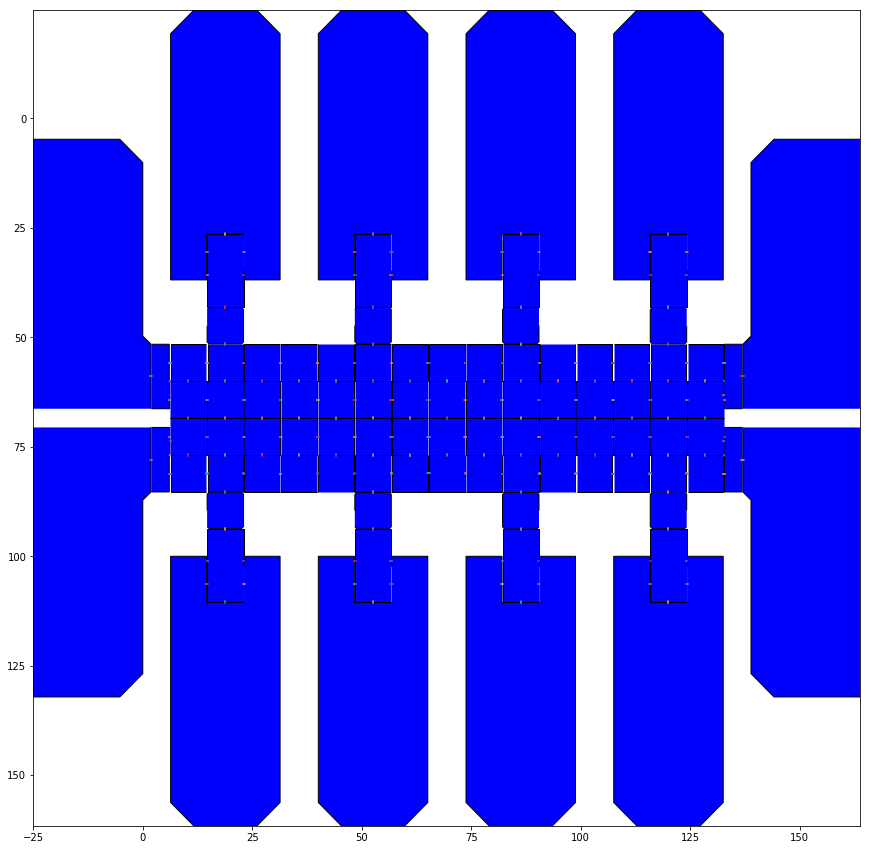

In [6]:
# Draw detected neighbours.
draw(df_shapes); pass

# Assign direction labels (i.e., `left`, `right`, `up`, `down`) to neighbours

In [7]:
df_segments = get_segments(df_shapes)
df_neighbours = df_intersections.reset_index([2, 3]).join(df_segments, lsuffix='_neighbour')

In [8]:
df_neighbours_i = df_neighbours.copy().reset_index('id').drop_duplicates(['id', 'id_neighbour'])

r = df_neighbours_i[['x_normal', 'y_normal']]

df_neighbours_i.insert(0, 'direction', None)

# Assign direction labels
vertical = df_neighbours_i.x_normal.abs() < df_neighbours_i.y_normal.abs()
df_neighbours_i.loc[vertical & (df_neighbours_i.y_normal < 0), 'direction'] = 'up'
df_neighbours_i.loc[vertical & (df_neighbours_i.y_normal > 0), 'direction'] = 'down'
df_neighbours_i.loc[~vertical & (df_neighbours_i.x_normal < 0), 'direction'] = 'left'
df_neighbours_i.loc[~vertical & (df_neighbours_i.x_normal > 0), 'direction'] = 'right'
# If multiple neighbours match a direction, only keep the first match.
df_neighbours_i.drop_duplicates(['id', 'direction'], inplace=True)

df_neighbours_i.sort_values(['id', 'direction']).set_index('id').head(16)  # .loc['electrode029']

,direction,id_neighbour,vertex_i_neighbour,vertex_i2_neighbour,x_neighbour,y_neighbour,x2_neighbour,y2_neighbour,x_mid_neighbour,y_mid_neighbour,...,vertex_i2,x,y,x2,y2,x_mid,y_mid,length,x_normal,y_normal
id,,,,,,,,,,,,,,,,,,,,,
electrode000,left,electrode043,1,2,6.049613,85.326280,6.049613,76.949429,6.049613,81.137855,...,2,6.349456,76.949429,6.349456,85.326280,6.349456,81.137855,8.376851,-0.377953,0.000000
electrode000,right,electrode002,2,3,14.782528,76.949429,14.782528,85.270062,14.782528,81.109746,...,4,14.482682,85.326280,14.482682,76.949429,14.482682,81.137855,8.376851,0.377953,0.000000
electrode000,up,electrode001,0,1,6.255755,76.836988,14.576385,76.836988,10.416070,76.836988,...,1,14.482682,76.949429,6.349456,76.949429,10.416069,76.949429,8.133226,-0.000000,-0.377953
electrode001,down,electrode000,0,1,14.482682,76.949429,6.349456,76.949429,10.416069,76.949429,...,1,6.255755,76.836988,14.576385,76.836988,10.416070,76.836988,8.320630,-0.000000,0.377953
electrode001,left,electrode043,3,4,6.143314,76.836988,6.143314,70.596519,6.143314,73.716754,...,4,6.255755,68.516360,6.255755,76.836988,6.255755,72.676674,8.320628,-0.377953,0.000000
electrode001,right,electrode006,3,4,14.688826,68.516360,14.688826,76.836988,14.688826,72.676674,...,2,14.576385,76.836988,14.576385,68.516360,14.576385,72.676674,8.320628,0.377953,0.000000
electrode001,up,electrode088,0,1,6.255755,68.403919,14.576385,68.403919,10.416070,68.403919,...,3,14.576385,68.516360,6.255755,68.516360,10.416070,68.516360,8.320630,-0.000000,-0.377953
electrode002,down,electrode037,6,7,22.538608,85.382502,15.159672,85.382502,18.849140,85.382502,...,4,14.782528,85.270062,22.915756,85.270062,18.849142,85.270062,8.133228,-0.000000,0.377953
electrode002,left,electrode000,3,4,14.482682,85.326280,14.482682,76.949429,14.482682,81.137855,...,3,14.782528,76.949429,14.782528,85.270062,14.782528,81.109746,8.320633,-0.377953,0.000000
